In [1]:
#NB: refer start of video 4 and start of video 5

In [2]:
sample_or_prod = False #True = sample, False = production

batch_size = 64 #ajust to suit memory capacity of hardware.

In [3]:
from theano.sandbox import cuda
cuda.use('gpu0')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



In [4]:
HOMEPATH = "/home/ubuntu/fastai/"

DATA_PATH = HOMEPATH+"data/Kaggle_dogs-vs-cats-redux-kernels-edition/"

MODEL_PATH = DATA_PATH+"models/"
RESULTS_PATH = DATA_PATH+"results/"


SAMPLE_DATA_PATH = DATA_PATH + "sample/"#choose this for testing or above for production
SAMPLE_TEST_PATH = SAMPLE_DATA_PATH+"test/"
SAMPLE_TRAIN_PATH = SAMPLE_DATA_PATH + "train/"
SAMPLE_VALID_PATH = SAMPLE_DATA_PATH + "valid/"


TEST_PATH = DATA_PATH+"test/"
TRAIN_PATH = DATA_PATH + "train/"
VALID_PATH = DATA_PATH + "valid/"


if sample_or_prod:
    WORKING_DATA  = SAMPLE_DATA_PATH
    WORKING_TEST  = SAMPLE_TEST_PATH
    WORKING_TRAIN = SAMPLE_TRAIN_PATH
    WORKING_VALID = SAMPLE_VALID_PATH
    s_or_p = "_sample_"
else:
    WORKING_DATA  = DATA_PATH
    WORKING_TEST  = TEST_PATH
    WORKING_TRAIN = TRAIN_PATH
    WORKING_VALID = VALID_PATH
    s_or_p = "_prod_"

    
print "WORKING_DATA:", WORKING_DATA
print "WORKING_TEST:", WORKING_TEST
print "WORKING_TRAIN:", WORKING_TRAIN
print "WORKING_VALID:", WORKING_VALID
print "s_or_p:", s_or_p


WORKING_DATA: /home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/
WORKING_TEST: /home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/test/
WORKING_TRAIN: /home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/train/
WORKING_VALID: /home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/valid/
s_or_p: _prod_


In [5]:
import os
from datetime import datetime
from glob import glob
from random import shuffle
from shutil import copyfile
import inspect  #this is used to introspect attributes of an object. Using because keras documentation is poor.

In [6]:
os.chdir(HOMEPATH)
print ("os.getcwd:", os.getcwd())
# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

('os.getcwd:', '/home/ubuntu/fastai')


Using Theano backend.


In [7]:
os.chdir(DATA_PATH)
print (os.getcwd())
!tree -d

/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition
.
├── models
│   ├── test_data.bc
│   │   ├── data
│   │   └── meta
│   ├── train_convlayer_features_prod_.bc
│   │   ├── data
│   │   └── meta
│   ├── train_convlayer_features_sample_.bc
│   │   ├── data
│   │   └── meta
│   ├── train_data_prod_.bc
│   │   ├── data
│   │   └── meta
│   ├── train_data_sample_.bc
│   │   ├── data
│   │   └── meta
│   ├── train_ll_feat.bc
│   │   ├── data
│   │   └── meta
│   ├── valid_convlayer_features_prod_.bc
│   │   ├── data
│   │   └── meta
│   ├── valid_convlayer_features_sample_.bc
│   │   ├── data
│   │   └── meta
│   ├── valid_data_prod_.bc
│   │   ├── data
│   │   └── meta
│   ├── valid_data_sample_.bc
│   │   ├── data
│   │   └── meta
│   └── valid_ll_feat.bc
│       ├── data
│       └── meta
├── results
├── sample
│   ├── test
│   │   └── unknown
│   ├── train
│   │   ├── cat
│   │   └── dog
│   └── valid
│       ├── cat
│       └── dog
├── test
│   └── unknown
├── train
│   

In [8]:
CATEGORIES = ['cat/', 'dog/']#nb: do not change order or trailing slash
UNKNOWN = 'unknown/'


In [9]:
DATA_DIR_LIST = [DATA_PATH, SAMPLE_DATA_PATH, SAMPLE_TEST_PATH, SAMPLE_TEST_PATH+UNKNOWN, SAMPLE_TRAIN_PATH, 
                 SAMPLE_VALID_PATH, TEST_PATH, TEST_PATH+UNKNOWN, TRAIN_PATH, VALID_PATH, MODEL_PATH, RESULTS_PATH]



for category in CATEGORIES:
    DATA_DIR_LIST.append(TRAIN_PATH+category)
    DATA_DIR_LIST.append(VALID_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_TRAIN_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_VALID_PATH+category)


#delete the variables we don't need to prevent accidental use.
del SAMPLE_DATA_PATH
del SAMPLE_TEST_PATH
del SAMPLE_TRAIN_PATH
del SAMPLE_VALID_PATH
del TEST_PATH
del TRAIN_PATH
del VALID_PATH


In [10]:
def dirFileList(dir_path):
    return [name for name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, name))]

In [11]:
def listDirsFileCount(DATA_DIR_LIST):
    DATA_DIR_LIST = sorted(DATA_DIR_LIST)
    for dir_ in DATA_DIR_LIST:
        print (dir_, len(dirFileList(dir_)))


In [12]:
def showLayersInfo(model):
    print ("Number of layers : ", len(model.layers))
    count = 0
    for layer in model.layers:
        print (count, type(layer), ", trainable:", layer.trainable)
        print ("input:", layer.input_shape, ", output:",layer.output_shape, ", len(weights)", len(layer.get_weights()), "\n")
        count +=1

In [13]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [14]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

In [15]:
listDirsFileCount(DATA_DIR_LIST)

/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/ 3
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/models/ 60
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/results/ 3
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/test/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/test/unknown/ 2500
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/cat/ 1750
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/dog/ 1750
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/cat/ 750
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/dog/ 75

In [16]:
trn_batches = get_batches(WORKING_TRAIN, shuffle=False, batch_size=batch_size)
val_batches = get_batches(WORKING_VALID, shuffle=False, batch_size=batch_size)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [17]:
print ("trn_batches:", type(trn_batches))
print ("val_batches:", type(val_batches))

trn_batches: <class 'keras.preprocessing.image.DirectoryIterator'>
val_batches: <class 'keras.preprocessing.image.DirectoryIterator'>


In [18]:
for i in inspect.getmembers(val_batches):
    # Ignores anything starting with underscore 
    # (that is, private and protected attributes)
    if not i[0].startswith('_'):
        # Ignores methods
        if not inspect.ismethod(i[1]):
            print(i)

('batch_index', 0)
('batch_size', 64)
('class_indices', {'dog': 1, 'cat': 0})
('class_mode', 'categorical')
('classes', array([0, 0, 0, ..., 1, 1, 1], dtype=int32))
('color_mode', 'rgb')
('dim_ordering', 'th')
('directory', '/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/valid/')
('filenames', ['cat/cat.10295.jpg', 'cat/cat.12038.jpg', 'cat/cat.6181.jpg', 'cat/cat.10573.jpg', 'cat/cat.2417.jpg', 'cat/cat.8398.jpg', 'cat/cat.9733.jpg', 'cat/cat.12009.jpg', 'cat/cat.2498.jpg', 'cat/cat.6320.jpg', 'cat/cat.6800.jpg', 'cat/cat.8503.jpg', 'cat/cat.7448.jpg', 'cat/cat.5693.jpg', 'cat/cat.10466.jpg', 'cat/cat.1983.jpg', 'cat/cat.8054.jpg', 'cat/cat.7394.jpg', 'cat/cat.6448.jpg', 'cat/cat.12451.jpg', 'cat/cat.10464.jpg', 'cat/cat.4735.jpg', 'cat/cat.3504.jpg', 'cat/cat.9121.jpg', 'cat/cat.4781.jpg', 'cat/cat.5385.jpg', 'cat/cat.5399.jpg', 'cat/cat.12073.jpg', 'cat/cat.7417.jpg', 'cat/cat.6533.jpg', 'cat/cat.8431.jpg', 'cat/cat.1248.jpg', 'cat/cat.1353.jpg', 'cat/cat.6301.jp

In [19]:
print ("WORKING_DATA:", WORKING_DATA)
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames) = get_classes(WORKING_DATA)
#utils.get_classes
#return (val_batches.classes, batches.classes, onehot(val_batches.classes), onehot(batches.classes),
#        val_batches.filenames, batches.filenames, test_batches.filenames)
#NB: get_classes expects data in subdirectories 'train', 'valid', 'test'
print ("val_classes:", type(val_classes), val_classes.shape, val_classes[0:5])
print ("trn_classes:", type(trn_classes), trn_classes.shape, trn_classes[0:5])
print ("val_labels:", type(val_labels), val_labels.shape, "\n", val_labels[0:5])
print ("trn_labels:", type(trn_labels), trn_labels.shape, "\n",trn_labels[0:5])
print ("val_filenames:", type(val_filenames), len(val_filenames))
print ("filenames:", type(filenames), len(filenames))
print ("test_filenames:", type(test_filenames), len(test_filenames))

#NBB: val_labels = onehot(val_classes) & trn_labels = onehot(trn_classes). onehot 'converts' from 1 to [0,1]

WORKING_DATA: /home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/
Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
val_classes: <type 'numpy.ndarray'> (7500,) [0 0 0 0 0]
trn_classes: <type 'numpy.ndarray'> (17500,) [0 0 0 0 0]
val_labels: <type 'numpy.ndarray'> (7500, 2) 
 [[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
trn_labels: <type 'numpy.ndarray'> (17500, 2) 
 [[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
val_filenames: <type 'list'> 7500
filenames: <type 'list'> 17500
test_filenames: <type 'list'> 12500


In [20]:
model = Vgg16().model
#model is stock vgg16 model, all layers trainable, input [3,224,224], output 1,000 classes. 
#needs to be modified to predict 2 classes.
#model.summary()

In [21]:
#showLayersInfo(model)

In [22]:
conv_layers,fc_layers = split_at(model, Convolution2D)
#utils.split_at(model, layer_type) 
#splits model at last occurrance of layer_type. (in this case Convolution2D)


In [23]:
print ("model        # of layers:",  len(model.layers))
print ("conv_layers  # of layers:",  len(conv_layers))
print ("fc_layers    # of layers:", len(fc_layers))

model        # of layers: 38
conv_layers  # of layers: 31
fc_layers    # of layers: 7


In [24]:
conv_model = Sequential(conv_layers)
#31 layers, all trainable, last layer = Convolution2D
#showLayersInfo(conv_model)

In [25]:
#showLayersInfo(Sequential(fc_layers))
#7 layers, all trainable, last layer = Dence, 1000 classes output.

In [26]:
startTime= datetime.now()
print ("startTime:", startTime)

#val_batches: <class 'keras.preprocessing.image.DirectoryIterator'>
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator
#

val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)
print ("val_features:", val_features.shape)
trn_features = conv_model.predict_generator(trn_batches, trn_batches.nb_sample)
print ("trn_features:", trn_features.shape)

timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#https://keras.io/models/sequential/
#predict_generator(self, generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
#Returns: A Numpy array of predictions.
#sample mode: takes approx 2 minutes to run/

startTime: 2017-12-22 23:31:10.320659
val_features: (7500, 512, 14, 14)
trn_features: (17500, 512, 14, 14)
Time elapsed (hh:mm:ss.ms) 0:10:50.140462


In [27]:
#save_array(MODEL_PATH + 'train_convlayer_features.bc', trn_features)
#save_array(MODEL_PATH + 'valid_convlayer_features.bc', val_features)

In [28]:
#trn_features = load_array(MODEL_PATH+'train_convlayer_features.bc')
#val_features = load_array(MODEL_PATH+'valid_convlayer_features.bc')

In [29]:
startTime= datetime.now()
print ("startTime:", startTime)

trn = get_data(WORKING_TRAIN)
print ("trn:", trn.shape)
val = get_data(WORKING_VALID)
print ("val:", val.shape)

timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))
#sample mode: tales approx 50s to run

startTime: 2017-12-22 23:42:00.482294
Found 17500 images belonging to 2 classes.
trn: (17500, 3, 224, 224)
Found 7500 images belonging to 2 classes.
val: (7500, 3, 224, 224)
Time elapsed (hh:mm:ss.ms) 0:04:10.039785


In [30]:
#save_array(MODEL_PATH+'train_data.bc', trn)
#save_array(MODEL_PATH+'valid_data.bc', val)

In [31]:
#trn = load_array(MODEL_PATH+'train_data.bc')
#val = load_array(MODEL_PATH+'valid_data.bc')

In [32]:
showLayersInfo(model)

Number of layers :  38
0 <class 'keras.layers.core.Lambda'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) , len(weights) 0 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) , len(weights) 0 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) , len(weights) 0 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) , len(weights) 0 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 112, 112) , output: (N

In [33]:
print ("@start# of layers:", len(model.layers))#should be 38 layers before popping
model.pop()
model.pop()
print ("@end# of layers:", len(model.layers))#should be 36 layers after popping
#showLayersInfo(model)

@start# of layers: 38
@end# of layers: 36


In [34]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
                                                                   zeropadding2d_1[1][0]            
___________________________________________________________________________________________

convolution2d_12 (Convolution2D) (None, 512, 14, 14)   2359808     zeropadding2d_12[0][0]           
                                                                   zeropadding2d_12[1][0]           
____________________________________________________________________________________________________
zeropadding2d_13 (ZeroPadding2D) (None, 512, 16, 16)   0           convolution2d_12[0][0]           
                                                                   convolution2d_12[1][0]           
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 512, 14, 14)   2359808     zeropadding2d_13[0][0]           
                                                                   zeropadding2d_13[1][0]           
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 512, 7, 7)     0           convolution2d_13[0][0]  

In [35]:
showLayersInfo(model)

Number of layers :  36
0 <class 'keras.layers.core.Lambda'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) , len(weights) 0 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) , len(weights) 0 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) , len(weights) 0 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) , len(weights) 0 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 112, 112) , output: (N

In [36]:
print ("trn_batches:", type(trn_batches), "trn_batches.nb_sample:", trn_batches.nb_sample)
print ("val_batches:", type(val_batches), "val_batches.nb_sample:", val_batches.nb_sample)

trn_batches: <class 'keras.preprocessing.image.DirectoryIterator'> trn_batches.nb_sample: 17500
val_batches: <class 'keras.preprocessing.image.DirectoryIterator'> val_batches.nb_sample: 7500


In [37]:
startTime= datetime.now()
print ("startTime:", startTime)

ll_val_feat = model.predict_generator(val_batches, val_batches.nb_sample)
print ("ll_val_feat:", ll_val_feat.shape)
ll_feat = model.predict_generator(trn_batches, trn_batches.nb_sample)
print ("ll_feat:", ll_feat.shape)

timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#NB: 64^2 = 4096
#sample mode: takes approx 2'11"

startTime: 2017-12-22 23:46:12.014708
ll_val_feat: (7500, 4096)
ll_feat: (17500, 4096)
Time elapsed (hh:mm:ss.ms) 0:10:40.625884


In [38]:
save_array(MODEL_PATH + 'train_ll_feat.bc', ll_feat)
save_array(MODEL_PATH + 'valid_ll_feat.bc', ll_val_feat)

In [39]:
#ll_feat = load_array(MODEL_PATH+ 'train_ll_feat.bc')
#ll_val_feat = load_array(MODEL_PATH + 'valid_ll_feat.bc')

In [40]:
startTime= datetime.now()
print ("startTime:", startTime)

test = get_data(WORKING_TEST)
#recall: utils: def get_data(path, target_size=(224,224)):
print (type(test), test.shape)

timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#sample mode: takes approx 

startTime: 2017-12-22 23:56:53.604545
Found 12500 images belonging to 1 classes.
<type 'numpy.ndarray'> (12500, 3, 224, 224)
Time elapsed (hh:mm:ss.ms) 0:02:48.970211


In [41]:
save_array(MODEL_PATH+'test_data.bc', test)

In [42]:
#test = load_array(MODEL_PATH+'test_data.bc')

In [43]:
def get_ll_layers():
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense
    return [ 
        BatchNormalization(input_shape=(4096,)),
        Dropout(0.5),
        Dense(2, activation='softmax') 
        ]

In [44]:
def train_last_layer(i):
    #nb: i is used in the filename to save weights.
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense
    #set learning rate, train model, set learning rate again, train model.
    #pop last three layers from vgg16 model, make all layers non trainable.
    #add 3 layers created in get_ll_layers to end of model.
    #copy weights from 3 layers just trained to last three layers in vgg16 model.
    ll_layers = get_ll_layers()
    ll_model = Sequential(ll_layers)
    ll_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    ll_model.optimizer.lr=1e-5
    history = ll_model.fit(ll_feat, trn_labels, validation_data=(ll_val_feat, val_labels), nb_epoch=12)
    print ("train_last_layer:i:", i, ", ll_model.optimizer.lr:", ll_model.optimizer.lr )
    plot_history(history)
    
    ll_model.optimizer.lr=1e-7
    ll_model.fit(ll_feat, trn_labels, validation_data=(ll_val_feat, val_labels), nb_epoch=1)
    #nb: cannot show history with only one epoch.
    print ("ll_model.optimizer.lr:", ll_model.optimizer.lr)
    ll_model.save_weights(MODEL_PATH+'ll_bn' + s_or_p + i + '.h5')

    #create new vgg16 model & pop last 3 layers.
    vgg = Vgg16()
    model = vgg.model
    print("train_last_layer, model just created from Vgg16(), # layers = ", len(model.layers))
    model.pop(); model.pop(); model.pop()
    #
    for layer in model.layers: layer.trainable=False
    #set all layers to non trainable
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    #create three layers ()
    ll_layers = get_ll_layers()
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense, add these layers to model.
    for layer in ll_layers: model.add(layer)
    #copy the weights from the above trained ll_model to the just added  last 3 layers in model.
    for l1,l2 in zip(ll_model.layers, model.layers[-3:]):
        l2.set_weights(l1.get_weights())
    
    #compile model so it is ready for use.
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.save_weights(MODEL_PATH+'bn' + s_or_p + i + '.h5')
    print ("@ end of train_last_layer, # layers = ", len(model.layers))
    showLayersInfo(model)
    return model

In [45]:
def get_conv_model(model):
    #split model into 2 sets of layers. 
    #conv_layers = start up to & including the last Convolution2D
    #fc_layers   = rest of the model
    #returns model, list of layers, int position of last Convolution2D layer. 
    
    layers = model.layers
    
    #last_conv_idx = index of last Convolution2D layer
    last_conv_idx = [index for index,layer in enumerate(layers) 
                         if type(layer) is Convolution2D][-1]

    conv_layers = layers[:last_conv_idx+1]
    conv_model = Sequential(conv_layers)
    fc_layers = layers[last_conv_idx+1:]
    return conv_model, fc_layers, last_conv_idx

In [46]:
def get_fc_layers(p, in_shape):
    #get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Dense, BatchNormalization, Dropout, Dense
    return [
        MaxPooling2D(input_shape=in_shape),
        Flatten(),
        Dense(4096, activation='relu'),
        #BatchNormalization(),
        Dropout(p),
        #Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(2, activation='softmax')
        ]

"""  
train_dense_layers: showLayersInfo(Sequential(fc_layers)):-----------START-----------  
Number of layers :  7  
0 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: False,input: (None, 512, 14, 14) , output: (None, 512, 7, 7)   
1 <class 'keras.layers.core.Flatten'> , trainable: False, input: (None, 512, 7, 7) , output: (None, 25088)   
2 <class 'keras.layers.core.Dense'> , trainable: False, input: (None, 25088) , output: (None, 4096)   
3 <class 'keras.layers.core.Dropout'> , trainable: False, input: (None, 4096) , output: (None, 4096)   
4 <class 'keras.layers.normalization.BatchNormalization'> , trainable: True, input: (None, 4096) , output: (None, 4096)   
5 <class 'keras.layers.core.Dropout'> , trainable: True, input: (None, 4096) , output: (None, 4096)   
6 <class 'keras.layers.core.Dense'> , trainable: True, input: (None, 4096) , output: (None, 2)   
"""  

In [47]:
def train_dense_layers(i, model):
    #nb: i is used in the filename to save weights.
    
    print ("start: train_dense_layers: i:", i)
    print ("len(model.layers):", len(model.layers))
    #split model about last Convolutional2D layer
    conv_model, fc_layers, last_conv_idx = get_conv_model(model)
    #conv_model = Sqeuential(conv_layers) = list of layers, from start up to & including the last Convolution2D layer.
    #fc_layers   = rest of the model       
    
    #shape of last Convolution2D layer output.
    conv_shape = conv_model.output_shape[1:]
    
    ##get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #conv_shape ensures input shape from conv_model can be accepted.
    fc_model = Sequential(get_fc_layers(0.5, conv_shape))
    #MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Dense, BatchNormalization, Dropout, Dense

    print ("train_dense_layers: showLayersInfo(fc_model):-----------START------------------------")
    showLayersInfo(fc_model)
    print ("train_dense_layers: showLayersInfo(Sequential(fc_layers)):-----------START-----------")
    showLayersInfo(Sequential(fc_layers))
    print ("-----------------------END-----------------------------------------------------------")
    print ("len(fc_model.layers):", len(fc_model.layers))#9 layers - as from def get_fc_layers
    print ("len(fc_layers):", len(fc_layers))            #7 layers - layers split from vgg16 after last Convolutional2D layer
    #copy weights from layers in fc_layers to the newly created fc_model. 
    count = 0
    for l1,l2 in zip(fc_model.layers, fc_layers): 
        print ("count:", count)
        print("l1:", l1)
        print("l2:", l2)
        weights = l2.get_weights()
        print ("l1.get_weights():", len(l1.get_weights()))
        print ("l2.get_weights():", len(l2.get_weights()))
        l1.set_weights(weights)
        count += 1
    
    print ("marker AA")
    fc_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    fc_model.fit(trn_features, trn_labels, nb_epoch=2, 
         batch_size=batch_size, validation_data=(val_features, val_labels))
    print ("marker BB")

    #setup data augmentation.
    gen = image.ImageDataGenerator(rotation_range=10, 
                                   width_shift_range=0.05, 
                                   #width_zoom_range=0.05, #error - why????
                                   zoom_range=0.05, 
                                   channel_shift_range=10, 
                                   height_shift_range=0.05, 
                                   shear_range=0.05, 
                                   horizontal_flip=True)
    print ("marker CC")

    batches = gen.flow(trn, trn_labels, batch_size=batch_size)
    
    print ("marker DD")

    val_batches = image.ImageDataGenerator().flow(val, 
                                                  val_labels, 
                                                  shuffle=False, 
                                                  batch_size=batch_size)
    
    print ("type(val_batches):", type(val_batches), "val_batches.n:", val_batches.n)

    print ("len(conv_model.layers):", len(conv_model.layers))
    
    #set all layers in conv_model set to non trainable
    for layer in conv_model.layers: 
        layer.trainable = False

    print ("marker EE-all layers in conv_model set to non trainable")
    ##get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Dense, BatchNormalization, Dropout, Dense
    #conv_shape ensures input shape from conv_model can be accepted.
    #add all layers to end of conv_model
    for layer in get_fc_layers(0.5, conv_shape): 
        conv_model.add(layer)
    print ("showLayersInfo(conv_model): after 1. setting layers to non trainable & 2. adding get_fc_layers to conv_model")
    showLayersInfo(conv_model)
        
    
    #copy weights from fc_model.layers to the layers after last_conv_idx in conv_model.
    #nb: weights in fc_model were trained 
    for l1,l2 in zip(conv_model.layers[last_conv_idx+1:], fc_model.layers): 
        l1.set_weights(l2.get_weights())
    print ("marker FF-copied weights from fc_model.layers to the layers after last_conv_idx in conv_model.")
    
    conv_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    conv_model.save_weights(MODEL_PATH+'no_dropout_bn' + s_or_p + i + '.h5')
    
    
    conv_model.fit_generator(batches, 
                             samples_per_epoch=batches.n, 
                             nb_epoch=1, 
                             validation_data=val_batches, 
                             nb_val_samples=val_batches.n)
    
    #now make more of the models trainable.
    for layer in conv_model.layers[16:]: layer.trainable = True

    print ("showLayersInfo(conv_model): after 1. copying weights to conv_model from fc_model.layers.")
    print ("2. fitting, setting layers 16: to trainable.")
    
    showLayersInfo(conv_model)


    history = conv_model.fit_generator(batches, 
                             samples_per_epoch=batches.n, 
                             nb_epoch=8, 
                             validation_data=val_batches, 
                             nb_val_samples=val_batches.n)

    print ("history = conv_model.fit_generator(blah....), conv_model.optimizer.lr:", conv_model.optimizer.lr)
    plot_history(history)
    
    conv_model.optimizer.lr = 1e-7
    history = conv_model.fit_generator(batches, 
                             samples_per_epoch=batches.n, 
                             nb_epoch=10, 
                             validation_data=val_batches, 
                             nb_val_samples=val_batches.n)

    print ("history = conv_model.fit_generator(blah....), conv_model.optimizer.lr:", conv_model.optimizer.lr)
    plot_history(history)
    
    conv_model.save_weights(MODEL_PATH + s_or_p + 'aug' + i + '.h5')

In [48]:
type(conv_model)

keras.models.Sequential

In [ ]:
#build the ensemble
#multiple model builds, model trainings. takes long time.
for i in range(5):
    i = str(i)
    print ("i:", i)
    model = train_last_layer(i)
    #a tthis point, model = vgg16 model, minus last three layers, plus layers BatchNormalization + Dropout + Dense
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense
    #train_last_layer uses get_ll_layers to create 3 layer model, trains it, then pops last 3 layers from vgg16model
    #at end of train_last_layer model has 38 layers with last three layers being BatchNormalization + Dropout + Dense

    train_dense_layers(i, model)

In [49]:
for i in range(5):
    print (MODEL_PATH + s_or_p + 'aug' + str(i) + '.h5')

/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/models/_prod_aug0.h5
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/models/_prod_aug1.h5
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/models/_prod_aug2.h5
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/models/_prod_aug3.h5
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/models/_prod_aug4.h5


Train on 17500 samples, validate on 7500 samples
Epoch 1/12
17500/17500 [==============================] - 4s - loss: 0.7958 - acc: 0.7037 - val_loss: 0.7185 - val_acc: 0.7725
Epoch 2/12
17500/17500 [==============================] - 4s - loss: 0.5826 - acc: 0.8064 - val_loss: 0.7725 - val_acc: 0.7975
Epoch 3/12
17500/17500 [==============================] - 4s - loss: 0.5478 - acc: 0.8356 - val_loss: 0.7801 - val_acc: 0.8043
Epoch 4/12
17500/17500 [==============================] - 4s - loss: 0.5275 - acc: 0.8456 - val_loss: 0.7804 - val_acc: 0.8075
Epoch 5/12
17500/17500 [==============================] - 4s - loss: 0.5134 - acc: 0.8471 - val_loss: 0.7754 - val_acc: 0.8093
Epoch 6/12
17500/17500 [==============================] - 4s - loss: 0.5030 - acc: 0.8527 - val_loss: 0.7641 - val_acc: 0.8095
Epoch 7/12
17500/17500 [==============================] - 4s - loss: 0.4963 - acc: 0.8522 - val_loss: 0.7601 - val_acc: 0.8116
Epoch 8/12
17500/17500 [==============================] - 4s -

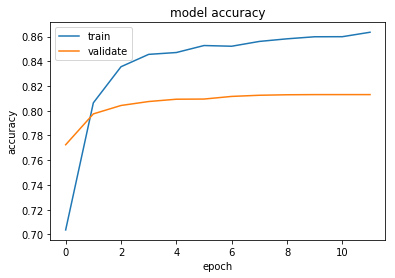

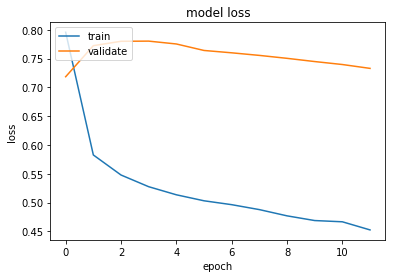

Train on 17500 samples, validate on 7500 samples
Epoch 1/1
17500/17500 [==============================] - 5s - loss: 0.4613 - acc: 0.8623 - val_loss: 0.7245 - val_acc: 0.8131
ll_model.optimizer.lr: 1e-07
train_last_layer, model just created from Vgg16(), # layers =  38
@ end of train_last_layer, # layers =  38
Number of layers :  38
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) , len(weights) 0 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) , len(weights) 0 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) , len(weights) 0 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 

In [50]:
ens_model2 = train_last_layer(str(11))

In [51]:
for layer in ens_model2.layers: layer.trainable=True

In [52]:
#Combine ensemble and test
#ens_model = vgg_ft(2)
#vgg_ft(2) returns Vgg16().ft(2).Vgg16() ie: vgg16 model set for 2 output classifications.
#for layer in ens_model.layers: layer.trainable=True

In [53]:
#showLayersInfo(ens_model)

In [54]:
def get_ens_pred(arr, fname):
    ens_pred = []
    for i in range(5):
        i = str(i)
        print ("loading weights file:", i)
        ens_model2.load_weights('{}{}{}.h5'.format(MODEL_PATH, fname, i))
        print ("predicting from weights file:", i)
        preds = ens_model2.predict(arr, batch_size=batch_size)
        ens_pred.append(preds)
        print ("len(ens_pred):", len(ens_pred), ", len(preds):", len(preds))
    return ens_pred

In [55]:
#recall: val = get_data(WORKING_VALID)
#val: (1500, 3, 224, 224)

val_pred2 = get_ens_pred(val, 'aug')
#nb: this loads weights from the files with 'aug' in filename. this is the final model build in method train_dense_layers

loading weights file: 0
predicting from weights file: 0
len(ens_pred): 1 , len(preds): 7500
loading weights file: 1
predicting from weights file: 1
len(ens_pred): 2 , len(preds): 7500
loading weights file: 2
predicting from weights file: 2
len(ens_pred): 3 , len(preds): 7500
loading weights file: 3
predicting from weights file: 3
len(ens_pred): 4 , len(preds): 7500
loading weights file: 4
predicting from weights file: 4
len(ens_pred): 5 , len(preds): 7500


In [56]:
print ("len(val_pred2):", len(val_pred2))
print(val_pred2[0].shape)
print(val_pred2[0][0:10, :])

len(val_pred2): 5
(7500, 2)
[[  9.9291e-01   7.0905e-03]
 [  9.9736e-01   2.6360e-03]
 [  9.9920e-01   7.9548e-04]
 [  9.9638e-01   3.6199e-03]
 [  1.0000e+00   1.5267e-06]
 [  9.9949e-01   5.0645e-04]
 [  5.5574e-01   4.4426e-01]
 [  8.7982e-01   1.2018e-01]
 [  1.0000e+00   1.0347e-06]
 [  9.9999e-01   1.2135e-05]]


In [57]:
#calc categorical_accuracy for each prediction and for the average.
cat_acc = []
for i in range(5):
    temp_val_preds = val_pred2[i]
    print ("i:", i, type(temp_val_preds), temp_val_preds.shape)
    cat_acc.append(float(categorical_accuracy(val_labels, temp_val_preds).eval()))
    print ("i:", i, type(temp_val_preds), temp_val_preds.shape, ", categorical accuracy:", cat_acc[i])
print ("cat_acc:", type(cat_acc), cat_acc)


i: 0 <type 'numpy.ndarray'> (7500, 2)
i: 0 <type 'numpy.ndarray'> (7500, 2) , categorical accuracy: 0.983733355999
i: 1 <type 'numpy.ndarray'> (7500, 2)
i: 1 <type 'numpy.ndarray'> (7500, 2) , categorical accuracy: 0.984533309937
i: 2 <type 'numpy.ndarray'> (7500, 2)
i: 2 <type 'numpy.ndarray'> (7500, 2) , categorical accuracy: 0.983066678047
i: 3 <type 'numpy.ndarray'> (7500, 2)
i: 3 <type 'numpy.ndarray'> (7500, 2) , categorical accuracy: 0.985466659069
i: 4 <type 'numpy.ndarray'> (7500, 2)
i: 4 <type 'numpy.ndarray'> (7500, 2) , categorical accuracy: 0.983733355999
cat_acc: <type 'list'> [0.9837333559989929, 0.9845333099365234, 0.9830666780471802, 0.9854666590690613, 0.9837333559989929]


In [58]:
val_avg_preds2 = np.stack(val_pred2).mean(axis=0)
#get the mean prediction across all 
print ("type(val_avg_preds2):", type(val_avg_preds2), val_avg_preds2.shape)
print(val_avg_preds2[0:10, :])

type(val_avg_preds2): <type 'numpy.ndarray'> (7500, 2)
[[  9.9196e-01   8.0370e-03]
 [  9.9598e-01   4.0153e-03]
 [  9.9959e-01   4.0921e-04]
 [  9.9888e-01   1.1243e-03]
 [  9.9999e-01   9.2497e-06]
 [  9.9962e-01   3.8046e-04]
 [  7.1704e-01   2.8296e-01]
 [  7.1177e-01   2.8823e-01]
 [  1.0000e+00   4.1831e-07]
 [  1.0000e+00   3.6545e-06]]


In [ ]:
print ("categorical accuracy from mean      :", float(categorical_accuracy(val_labels, val_avg_preds2).eval()))
print ("best individual categorical accuracy:", np.max(cat_acc))
#NB: mean accuracy is higher because it is choosing the best prediction row by row. then comparing with actual category.

categorical accuracy from mean      : 0.986266672611
best individual categorical accuracy: 0.985466659069


In [ ]:
#recall: test = get_data(WORKING_TEST)
#<type 'numpy.ndarray'> (2500, 3, 224, 224)
startTime= datetime.now()
print ("startTime:", startTime)
test_pred2 = get_ens_pred(test, 'aug')
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))


#print ("test_pred2.shape:", test_pred2.shape)
#approx time to run : production version: 

startTime: 2017-12-23 00:18:04.520894
loading weights file: 0
predicting from weights file: 0
len(ens_pred): 1 , len(preds): 12500
loading weights file: 1
predicting from weights file: 1
len(ens_pred): 2 , len(preds): 12500
loading weights file: 2
predicting from weights file: 2
len(ens_pred): 3 , len(preds): 12500
loading weights file: 3
predicting from weights file: 3


In [ ]:
#depending on shape of test_pred2, modify code from Kaggle-cats-dogs-redux-4-reload_model_predict
#to produce kaggle submit format 


In [ ]:
print ("len(val_pred2):", len(test_pred2))
print(test_pred2[0].shape)
print(test_pred2[0][0:10, :])

In [ ]:
avg_test_pred2 = np.stack(test_pred2).mean(axis=0)
#get the mean prediction across all 
print ("type(avg_test_pred2):", type(avg_test_pred2), avg_test_pred2.shape)
print(avg_test_pred2[0:10, :])

In [ ]:
#isdog = avg_test_pred2.clip(min=0.05, max=0.95)
#isdog = avg_test_pred2.clip(min=0.02, max=0.98)#try a different clip
isdog = avg_test_pred2.clip(min=0.01, max=0.99)#try a different clip

In [ ]:
print (type(isdog), isdog.shape)


In [ ]:
print(isdog[0:10])

In [ ]:
print ("test_filenames:", type(test_filenames), len(test_filenames))
print ("test_filenames[0:10]\n", test_filenames[0:10])
ids = np.array([int(f[8:f.find('.')]) for f in test_filenames])
print ("ids[0:10]\n", ids[0:10])


In [ ]:
subm = np.stack([ids,isdog], axis=1)
subm[:10]

In [ ]:
subm = subm[subm[:,0].argsort()]

In [ ]:
subm[:10]

In [ ]:
%cd $RESULTS_PATH
submission_file_name = "submission1_cats-dogs-redux-ensemble"+ s_or_p +"01-99.csv"
np.savetxt(submission_file_name, subm, fmt='%d,%.2f', header='id,label', comments='')